<font size=6>**计算机视觉**</font>

# 图像增广
在“深度卷积神经网络（AlexNet）”小节里我们提到过，大规模数据集是成功应用深度神经网络的前提。图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以**降低模型对某些属性的依赖**，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年AlexNet的成功中，图像增广技术功不可没。本节我们将讨论这个在计算机视觉里被广泛使用的技术。

首先，导入实验所需的包或模块。

In [1]:
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd,init,gluon,nd,image
from mxnet.gluon import data as gdata,loss as gloss,utils as gutils
import sys
import time
%matplotlib inline

## 常用的图像增广的方法
我们来读取一张形状为 400×500 （高和宽分别为400像素和500像素）的图像作为实验的样例。

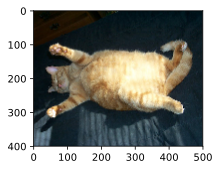

In [2]:
d2l.set_figsize()
img=image.imread('./img/cat1.jpg')
d2l.plt.imshow(img.asnumpy())

下面定义绘图函数show_images。

In [3]:
def show_images(imgs,num_rows,num_cols,scale=2):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数apply。这个函数对输入图像img多次运行图像增广方法aug并展示所有的结果。

In [4]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1):
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y,num_rows,num_cols,scale)

## 图像翻转和裁剪
左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过transforms模块创建RandomFlipLeftRight实例来实现一半概率的图像左右翻转。

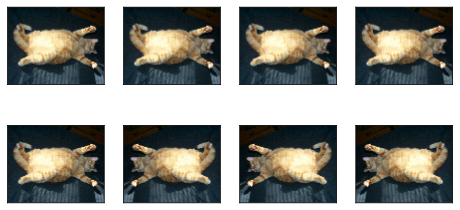

In [5]:
apply(img,gdata.vision.transforms.RandomFlipLeftRight(),scale=2)

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建RandomFlipTopBottom实例来实现一半概率的图像上下翻转。

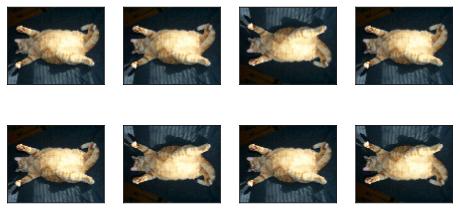

In [6]:
apply(img,gdata.vision.transforms.RandomFlipTopBottom(),scale=2)

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在“池化层”一节里我们解释了池化层能降低卷积层对目标位置的敏感度。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积 10%∼100% 的区域，且该区域的宽和高之比随机取自 0.5∼2 ，然后再将该区域的宽和高分别缩放到200像素。若无特殊说明，本节中 a 和 b 之间的随机数指的是从区间 [a,b] 中随机均匀采样所得到的连续值。

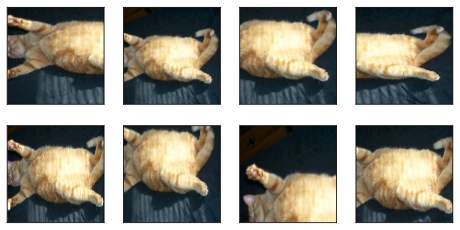

In [7]:
shape_aug=gdata.vision.transforms.RandomResizedCrop((200,200),scale=(0.1,1),ratio=(0.5,2))
apply(img,aug=shape_aug,scale=2)

## 颜色变化

另一类增广方法是变化颜色。我们可以从4个方面改变图像的颜色：亮度、对比度、饱和度和色调。在下面的例子里，我们将图像的亮度随机变化为原图亮度的 50% （ 1−0.5 ） ∼150% （ 1+0.5 ）。

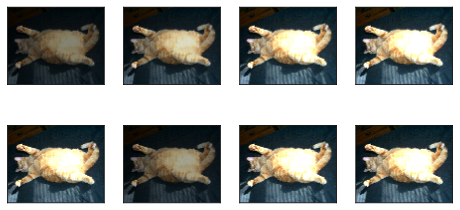

In [8]:
apply(img,gdata.vision.transforms.RandomBrightness(0.5),scale=2)

我们也可以随机变化图像的色调。

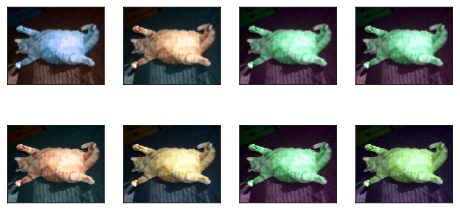

In [9]:
apply(img,gdata.vision.transforms.RandomHue(0.5),scale=2)

我们也可以创建RandomColorJitter实例并同时设置如何随机变化图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。

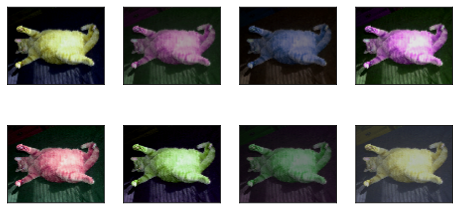

In [10]:
color_aug=gdata.vision.transforms.RandomColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5)
apply(img,color_aug,scale=2)

## 叠加多个图像增广方法
实际应用中我们会将多个图像增广方法叠加使用。我们可以通过Compose实例将上面定义的多个图像增广方法叠加起来，再应用到每张图像之上。

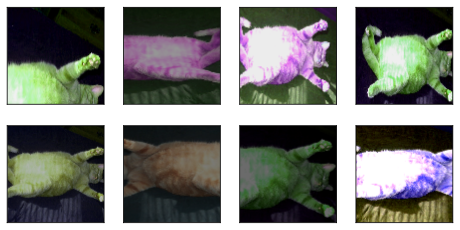

In [11]:
augs=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(),color_aug,shape_aug])
apply(img,augs,scale=2)

## 使用图片增广训练模型
下面我们来看一个将图像增广应用在实际训练中的例子。这里我们使用CIFAR-10数据集，而不是之前我们一直使用的Fashion-MNIST数据集。这是因为Fashion-MNIST数据集中物体的位置和尺寸都已经经过归一化处理，而CIFAR-10数据集中物体的颜色和大小区别更加显著。下面展示了CIFAR-10数据集中前32张训练图像。

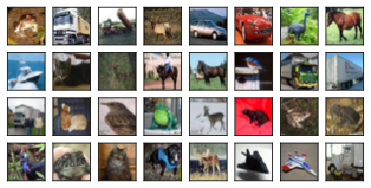

In [12]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0],4,8,scale=0.8);

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。在这里我们只使用最简单的随机左右翻转。此外，我们使用ToTensor实例将小批量图像转成MXNet需要的格式，即形状为(批量大小, 通道数, 高, 宽)、值域在0到1之间且类型为32位浮点数。

In [13]:
flip_aug=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(),gdata.vision.transforms.ToTensor()])
no_aug=gdata.vision.transforms.Compose([gdata.vision.transforms.ToTensor()])

接下来我们定义一个辅助函数来方便读取图像并应用图像增广。Gluon的数据集提供的transform_first函数将图像增广应用在每个训练样本（图像和标签）的第一个元素，即图像之上。有关DataLoader的详细介绍，可参考更早的“图像分类数据集（Fashion-MNIST）”一节。

In [21]:
num_works=0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train,augs,batch_size):
    return gdata.DataLoader(gdata.vision.CIFAR10(train=is_train).transform_first(augs),
                            batch_size=batch_size,shuffle=is_train,num_workers=num_works)

## 使用多GPU训练网络模型
首先，我们定义try_all_gpus函数，从而能够获取所有可用的GPU。

In [15]:
def try_all_gpu():
    ctxes=[]
    try:
        for i in range(16):
            ctx=mx.gpu(i)
            _=nd.array([0],ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes=[mx.cpu()]
    return ctxes

下面定义的辅助函数\_get_batch将小批量数据样本batch划分并复制到ctx变量所指定的各个显存上。

In [16]:
def _get_batch(batch,ctx):
    features,labels=batch
    if labels.dtype!=features.dtype:
        labels=labels.astype(features.dtype)
    return (gutils.split_and_load(features,ctx),gutils.split_and_load(labels,ctx),features.shape[0])

然后，我们定义evaluate_accuracy函数评价模型的分类准确率。与“softmax回归的从零开始实现”和“卷积神经网络（LeNet）”两节中描述的evaluate_accuracy函数不同，这里定义的函数更加通用：它通过辅助函数\_get_batch使用ctx变量所包含的所有GPU来评价模型。

In [17]:

In [17]:
def evaluate_accuracy(data_iter,net,ctx=[mx.cpu()]):
    if isinstance(ctx,mx.Context):#不是列表转化为列表
        ctx=[ctx]
    acc_sum,n=nd.array([0]),0
    for batch in data_iter:
        features,labels,_=_get_batch(batch,ctx)
        for X,y in zip(features,labels):
            y=y.astype('float32')
            acc_sum+=(net(X).argmax(axis=1)==y).sum().copyto(mx.cpu())
            n+=y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar()/n

接下来，我们定义train函数使用多GPU训练并评价模型。

In [27]:
def train(net,train_iter,test_iter,loss,trainer,ctx,num_epochs):
    print('training on',ctx)
    if isinstance(ctx,mx.Context):
        ctx=[ctx]
    for epoch in range(num_epochs):
        train_ls_sum,train_acc_sum,n,m,start=0.0,0.0,0,0,time.time()
        for i,batch in enumerate(train_iter):
            Xs,ys,batch_size=_get_batch(batch,ctx)
            ls=[]
            with autograd.record():
                y_hats=[net(X) for X in Xs]
                ls=[loss(y_hat,y) for y_hat,y in zip(y_hats,ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_ls_sum+=sum([l.sum().asscalar() for l in ls])
            n+=sum([l.size for l in ls])
            train_acc_sum+=sum([(y_hat.argmax(axis=1)==y).sum().asscalar() for y_hat,y in zip(y_hats,ys)])
            m+=sum([y.size for y in ys])
        test_acc=evaluate_accuracy(test_iter,net,ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_ls_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

现在就可以定义train_with_data_aug函数使用图像增广来训练模型了。该函数获取了所有可用的GPU，并将Adam算法作为训练使用的优化算法，然后将图像增广应用于训练数据集之上，最后调用刚才定义的train函数训练并评价模型。

In [19]:
def train_with_data_aug(train_augs,test_augs,lr=0.001):
    batch_size,ctx,net=256,try_all_gpu(),d2l.resnet18(10)
    net.initialize(ctx=ctx,init=init.Xavier())
    trainer=gluon.Trainer(net.collect_params(),'adam',{'learning_rate':lr})
    loss=gloss.SoftmaxCrossEntropyLoss()
    train_iter=load_cifar10(True,train_augs,batch_size)
    test_iter=load_cifar10(False,test_augs,batch_size)
    train(net,train_iter,test_iter,loss,trainer,ctx,num_epochs=2)

In [28]:
train_with_data_aug(flip_aug,no_aug)

training on [gpu(0)]
epoch 1, loss 1.3726, train acc 0.515, test acc 0.570, time 121.6 sec
epoch 2, loss 0.8124, train acc 0.711, test acc 0.698, time 119.0 sec


## 思考
对image进行tranform是非常耗时的，可以使用第三方库方法来进行图片增广，如opencv。

# 微调
在前面的一些章节中，我们介绍了如何在只有6万张图像的Fashion-MNIST训练数据集上训练模型。我们还描述了学术界当下使用最广泛的大规模图像数据集ImageNet，它有超过1,000万的图像和1,000类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出100种常见的椅子，为每种椅子拍摄1,000张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比Fashion-MNIST数据集要庞大，但样本数仍然不及ImageNet数据集中样本数的十分之一。这可能会导致适用于ImageNet数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。

本节我们介绍迁移学习中的一种常用技术：微调（fine tuning）。如图9.1所示，微调由以下4步构成。

* 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型。
* 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
* 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
* 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。
![](http://zh.d2l.ai/_images/finetune.svg)
当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。

## 热狗识别
接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在ImageNet数据集上训练好的ResNet模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

首先，导入实验所需的包或模块。Gluon的model_zoo包提供了常用的预训练模型。如果希望获取更多的计算机视觉的预训练模型，可以使用GluonCV工具包 [1]。

In [1]:
import d2lzh as d2l
from mxnet import gluon,init,nd
from mxnet.gluon import data as gdata,loss as gloss,model_zoo
from mxnet.gluon import utils as gutils
import os
import zipfile
%matplotlib inline

## 获取数据集
我们使用的热狗数据集是从网上抓取的，它含有1400张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的1000张图像被用于训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径../data之下，然后在该路径将下载好的数据集解压，得到两个文件夹hotdog/train和hotdog/test。这两个文件夹下面均有hotdog和not-hotdog两个类别文件夹，每个类别文件夹里面是图像文件。

In [2]:
data_dir='./data'
base_url='http://apache-mxnet.s3-accelerate.amazonaws.com/'
fname=gutils.download(base_url+'gluon/dataset/hotdog.zip',path=data_dir,sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
with zipfile.ZipFile(fname,'r') as z:
    z.extractall(data_dir)

我们创建两个ImageFolderDataset实例来分别读取训练数据集和测试数据集中的所有图像文件。

In [3]:
train_imgs=gdata.vision.ImageFolderDataset(os.path.join(data_dir,'hotdog/train'))
test_imgs=gdata.vision.ImageFolderDataset(os.path.join(data_dir,'hotdog/test'))

下面画出前8张正类图像和最后8张负类图像。可以看到，它们的大小和高宽比各不相同。

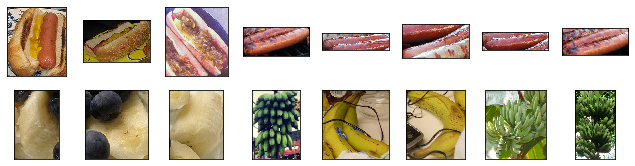

In [4]:
hotdogs=[train_imgs[i][0] for i in range(8)]
not_hotdogs=[train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs,2,8,scale=1.4);

在训练时，我们先从图像中裁剪出随机大小和随机高宽比的一块随机区域，然后将该区域缩放为高和宽均为224像素的输入。测试时，我们将图像的高和宽均缩放为256像素，然后从中裁剪出高和宽均为224像素的中心区域作为输入。此外，我们对RGB（红、绿、蓝）三个颜色通道的数值做标准化：每个数值减去该通道所有数值的平均值，再除以该通道所有数值的标准差作为输出。

In [5]:
normalize=gdata.vision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])#三个通道的均值和方差

train_augs=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomResizedCrop((224,224)),
                                           gdata.vision.transforms.RandomFlipLeftRight(),
                                           gdata.vision.transforms.ToTensor(),
                                           normalize])
test_augs=gdata.vision.transforms.Compose([gdata.vision.transforms.Resize((256,256)),
                                          gdata.vision.transforms.CenterCrop(224),
                                          gdata.vision.transforms.ToTensor(),
                                          normalize])

 ## 定义和初始化模型
 我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。这里指定pretrained=True来自动下载并加载预训练的模型参数。在第一次使用时需要联网下载模型参数。

In [6]:
pretrained_net=model_zoo.vision.resnet18_v2(pretrained=True)

预训练的源模型实例含有两个成员变量，即features和output。前者包含模型除输出层以外的所有层，后者为模型的输出层。这样划分主要是为了方便微调除输出层以外所有层的模型参数。下面打印源模型的成员变量output。作为一个全连接层，它将ResNet最终的全局平均池化层输出变换成ImageNet数据集上1000类的输出。

In [7]:
pretrained_net.output

Dense(512 -> 1000, linear)

我们新建一个神经网络作为目标模型。它的定义与预训练的源模型一样，但最后的输出个数等于目标数据集的类别数。在下面的代码中，目标模型实例finetune_net的成员变量features中的模型参数被初始化为源模型相应层的模型参数。由于features中的模型参数是在ImageNet数据集上预训练得到的，已经足够好，因此一般只需使用较小的学习率来微调这些参数。而成员变量output中的模型参数采用了随机初始化，一般需要更大的学习率从头训练。假设Trainer实例中的学习率为 η ，我们设成员变量output中的模型参数在迭代中使用的学习率为 10η 。

In [8]:
finetune_net=model_zoo.vision.resnet18_v2(classes=2)#定义一个和源模型一样的目标模型，只是输出层不一样
finetune_net.features=pretrained_net.features #将源模型处理输出层的参数copy到目标模型
finetune_net.output.initialize(init=init.Xavier()) #只对输出层参数进行初始化

# output中的模型参数将在迭代中使用10倍大的学习率
finetune_net.output.collect_params().setattr('lr_mult',10)

## 微调模型
我们先定义一个使用微调的训练函数train_fine_tuning以便多次调用。

In [11]:
def train_fime_tuning(net,learning_rate,batch_size=64,num_epochs=5):
    train_iter=gdata.DataLoader(train_imgs.transform_first(train_augs),batch_size,shuffle=True)
    test_iter=gdata.DataLoader(test_imgs.transform_first(test_augs),batch_size)
    ctx=d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    loss=gloss.SoftmaxCrossEntropyLoss()
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':learning_rate,'wd':0.001})
    d2l.train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs)

In [12]:
train_fime_tuning(finetune_net,0.01,num_epochs=1)

training on [gpu(0)]


MXNetError: [11:23:39] c:\jenkins\workspace\mxnet\mxnet\src\operator\tensor\../mxnet_op.h:680: Check failed: err == cudaSuccess (2 vs. 0) Name: mxnet_generic_kernel ErrStr:out of memory

可以看到，微调的模型因为参数初始值更好，往往在相同迭代周期下取得更高的精度。

## 练习
* 将finetune_net.features中的参数固定为源模型的参数而不在训练中迭代，结果会怎样？你可能会用到以下代码。
finetune_net.features.collect_params().setattr('grad_req','null')

* 事实上ImageNet数据集里也有“hotdog”（热狗）这个类。它在输出层对应的权重参数可以用以下代码获取。我们可以怎样使用这个权重参数？

In [11]:
weight=pretrained_net.output.weight
hotdog_w=nd.split(weight.data(),1000,axis=0)[713]
hotdog_w.shape

(1, 512)

In [14]:
nd.split(nd.array([[1,2,3],[4,5,6]]),2,axis=0)

[
 [[1. 2. 3.]]
 <NDArray 1x3 @cpu(0)>, 
 [[4. 5. 6.]]
 <NDArray 1x3 @cpu(0)>]

# 目标检测和边界框
在前面的一些章节中，我们介绍了诸多用于图像分类的模型。在图像分类任务里，我们假设图像里只有一个主体目标，并关注如何识别该目标的类别。然而，很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉里，我们将这类任务称为目标检测（object detection）或物体检测。

目标检测在多个领域中被广泛使用。例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍的位置来规划行进线路。机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。

在接下来的几节里，我们将介绍目标检测里的多个深度学习模型。在此之前，让我们来了解目标位置这个概念。先导入实验所需的包或模块。

In [2]:
import d2lzh as d2l
from mxnet import image
%matplotlib inline

下面加载本节将使用的示例图像。可以看到图像左边是一只狗，右边是一只猫。它们是这张图像里的两个主要目标。

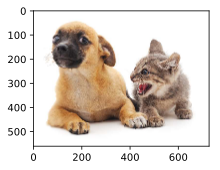

In [3]:
d2l.set_figsize()
img=image.imread('./img/catdog.jpg').asnumpy()
d2l.plt.imshow(img)

## 边界框
在目标检测里，我们通常使用边界框（bounding box）来描述目标位置。边界框是一个矩形框，可以由矩形左上角的 x 和 y 轴坐标与右下角的 x 和 y 轴坐标确定。我们根据上面的图的坐标信息来定义图中狗和猫的边界框。图中的坐标原点在图像的左上角，原点往右和往下分别为 x 轴和 y 轴的正方向。

In [4]:
dog_bbox,cat_bbox=[60,45,378,516],[400,112,655,493]

我们可以在图中将边界框画出来，以检查其是否准确。画之前，我们定义一个辅助函数bbox_to_rect。它将边界框表示成matplotlib的边界框格式。

In [5]:
def bbox_to_rect(bbox,color):
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return d2l.plt.Rectangle(xy=(bbox[0],bbox[1]),width=bbox[2]-bbox[0],height=bbox[3]-bbox[1],fill=False,edgecolor=color,linewidth=2)

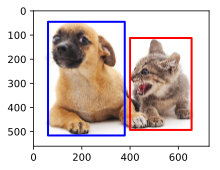

In [6]:
fig=d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox,'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox,'red'));

In [7]:
fig.axes

# 锚框
目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边缘从而更准确地预测目标的真实边界框（ground-truth bounding box）。不同的模型使用的区域采样方法可能不同。这里我们介绍其中的一种方法：它以每个像素为中心生成多个大小和宽高比（aspect ratio）不同的边界框。这些边界框被称为锚框（anchor box）。我们将在后面基于锚框实践目标检测。

首先，导入本节需要的包或模块。这里我们新引入了contrib包，并修改了NumPy的打印精度。由于NDArray的打印实际调用NumPy的打印函数，本节打印出的NDArray中的浮点数更简洁一些。

In [8]:
import d2lzh as d2l
from mxnet import contrib,gluon,image,nd
import numpy as np
%matplotlib inline

In [9]:
np.set_printoptions(2) #设置打印类型

## 生成多个锚框
假设输入图像高为 h ，宽为 w 。我们分别以图像的每个像素为中心生成不同形状的锚框。设大小为 s∈(0,1] 且宽高比为 r>0 ，那么锚框的宽和高将分别为 $ws\sqrt{r} 和 \frac{hs}{\sqrt{r}}$ 。当中心位置给定时，已知宽和高的锚框是确定的。

下面我们分别设定好一组大小 $s_1,…,s_n$ 和一组宽高比 $r_1,…,r_m$ 。如果以每个像素为中心时使用所有的大小与宽高比的组合，输入图像将一共得到 $whnm$ 个锚框。虽然这些锚框可能覆盖了所有的真实边界框，但计算复杂度容易过高。因此，我们通常只对包含 $s_1 或 r_1$ 的大小与宽高比的组合感兴趣，即

$(s_1,r_1),(s_1,r_2),…,(s_1,r_m),(s_2,r_1),(s_3,r_1),…,(s_n,r_1)$.
 
也就是说，以相同像素为中心的锚框的数量为 n+m−1 。对于整个输入图像，我们将一共生成 $wh(n+m−1)$ 个锚框。

以上生成锚框的方法已实现在**MultiBoxPrior**函数中。指定输入、一组大小和一组宽高比，该函数将返回输入的所有锚框。

In [10]:
img=image.imread('./img/catdog.jpg').asnumpy()
h,w=img.shape[0:2]

print(h,w)
X=nd.random.uniform(shape=(1,3,h,w))#构造输入数据
Y=contrib.nd.MultiBoxPrior(X,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5])
Y.shape

561 728


(1, 2042040, 4)

In [11]:
Y[0]


[[-0.29 -0.37  0.29  0.38]
 [-0.19 -0.25  0.19  0.25]
 [-0.1  -0.12  0.1   0.13]
 ...
 [ 0.9   0.87  1.1   1.12]
 [ 0.59  0.73  1.41  1.26]
 [ 0.79  0.47  1.2   1.53]]
<NDArray 2042040x4 @cpu(0)>

我们看到，返回锚框变量y的形状为（批量大小，锚框个数，4）。将锚框变量y的形状变为（图像高，图像宽，以相同像素为中心的锚框个数，4）后，我们就可以通过指定像素位置来获取所有以该像素为中心的锚框了。下面的例子里我们访问以（250，250）为中心的第一个锚框。它有4个元素，分别是锚框左上角的 x 和 y 轴坐标和右下角的 x 和 y 轴坐标，其中 x 和 y 轴的坐标值分别已除以图像的宽和高，因此值域均为0和1之间。

In [15]:
boxes=Y.reshape(h,w,-1,4)
boxes[250,250,:,:]


[[ 0.06  0.07  0.63  0.82]
 [ 0.15  0.2   0.54  0.7 ]
 [ 0.25  0.32  0.44  0.57]
 [-0.06  0.18  0.75  0.71]
 [ 0.14 -0.08  0.55  0.98]]
<NDArray 5x4 @cpu(0)>

为了描绘图像中以某个像素为中心的所有锚框，我们先定义show_bboxes函数以便在图像上画出多个边界框。

In [44]:
def show_bboxes(axes,bboxes,labels=None,colors=None):
    def _make_list(obj,default_values=None):
        if obj is None:
            obj=default_values
        elif not isinstance(obj,(list,tuple)):
            obj=[obj]
        return obj
    
    labels=_make_list(labels)
    colors=_make_list(colors,['b','g','r','m','c'])
    for i,bbox in enumerate(bboxes):
        color=colors[i%len(colors)]
        rect=d2l.bbox_to_rect(bbox.asnumpy(),color)
        axes.add_patch(rect)
        if labels and len(labels)>i:
            text_color='k' if color=='w' else 'w' #文字的颜色在k和w翻转。若边框为w则文字为k，否则为w w:白色
            axes.text(rect.xy[0],rect.xy[1],labels[i],  
                     va='center',ha='center',fontsize=9,
                     color=text_color,bbox=dict(facecolor=color,lw=0))#这里bbox为文字的边框

刚刚我们看到，变量boxes中 x 和 y 轴的坐标值分别已除以图像的宽和高。在绘图时，我们需要恢复锚框的原始坐标值，并因此定义了变量bbox_scale。现在，我们可以画出图像中以(250, 250)为中心的所有锚框了。可以看到，大小为0.75且宽高比为1的锚框较好地覆盖了图像中的狗。

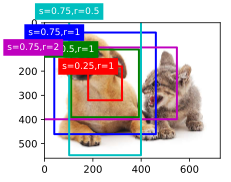

In [14]:
d2l.set_figsize()
bbox_scale=nd.array((w,h,w,h))#恢复原始坐标值
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,boxes[250,250,:,:]*bbox_scale,
           ['s=0.75,r=1','s=0.5,r=1','s=0.25,r=1','s=0.75,r=2','s=0.75,r=0.5'])

## 交并化
我们刚刚提到某个锚框较好地覆盖了图像中的狗。如果该目标的真实边界框已知，这里的“较好”该如何量化呢？一种直观的方法是衡量锚框和真实边界框之间的相似度。我们知道，Jaccard系数（Jaccard index）可以衡量两个集合的相似度。给定集合 A 和 B ，它们的Jaccard系数即二者交集大小除以二者并集大小：

$J(A,B)=\frac{|A∩B|}{|A∪B|}.$
 
实际上，我们可以把边界框内的像素区域看成是像素的集合。如此一来，我们可以用两个边界框的像素集合的Jaccard系数衡量这两个边界框的相似度。当衡量两个边界框的相似度时，我们通常将Jaccard系数称为交并比（Intersection over Union，IoU），即两个边界框相交面积与相并面积之比，如图9.2所示。交并比的取值范围在0和1之间：0表示两个边界框无重合像素，1表示两个边界框相等。

![](http://zh.d2l.ai/_images/iou.svg)
在本节的剩余部分，我们将使用交并比来衡量锚框与真实边界框以及锚框与锚框之间的相似度。

## 标注训练集的锚框
在训练集中，我们将每个锚框视为一个训练样本。为了训练目标检测模型，我们需要为每个锚框标注两类标签：一是锚框所含目标的类别，简称类别；二是真实边界框相对锚框的偏移量，简称偏移量（offset）。在目标检测时，我们首先生成多个锚框，然后为每个锚框预测类别以及偏移量，接着根据预测的偏移量调整锚框位置从而得到预测边界框，最后筛选需要输出的预测边界框。

我们知道，在目标检测的训练集中，每个图像已标注了真实边界框的位置以及所含目标的类别。在生成锚框之后，我们主要依据与锚框相似的真实边界框的位置和类别信息为锚框标注。那么，该如何为锚框分配与其相似的真实边界框呢？

假设图像中锚框分别为 $A_1,A_2,…,A_{n_a}$ ，真实边界框分别为 $B_1,B_2,…,B_{n_b}$ ，且 $n_a≥n_b$ 。定义矩阵 $X∈R^{n_a×n_b}$ ，其中第 i 行第 j 列的元素 $x_{ij}$ 为锚框 $A_i$ 与真实边界框 $B_j$ 的交并比。 首先，我们找出矩阵 X 中最大元素，并将该元素的行索引与列索引分别记为 $i_1,j_1$ 。我们为锚框 $A_{i_1}$ 分配真实边界框 $B_{j_1}$ 。显然，锚框 $A_{i_1}$ 和真实边界框 $B_{j_1}$ 在所有的“锚框—真实边界框”的配对中相似度最高。接下来，将矩阵 X 中第 $i_1$ 行和第 $j_1$ 列上的所有元素丢弃。找出矩阵 X 中剩余的最大元素，并将该元素的行索引与列索引分别记为 $i_2,j_2$ 。我们为锚框 $A_{i_2}$ 分配真实边界框 $B_{j_2}$ ，再将矩阵 X 中第 $i_2$ 行和第 $j_2$ 列上的所有元素丢弃。此时矩阵 X 中已有两行两列的元素被丢弃。 依此类推，直到矩阵 X 中所有 $n_b$ 列元素全部被丢弃。这个时候，我们已为 $n_b$ 个锚框各分配了一个真实边界框。 接下来，我们只遍历剩余的 $n_a−n_b$ 个锚框：给定其中的锚框 $A_i$ ，根据矩阵 X 的第 i 行找到与 $A_i$ 交并比最大的真实边界框 $B_j$ ，且只有当该交并比大于预先设定的阈值时，才为锚框 $A_i$ 分配真实边界框 $B_j$ 。

如图9.3（左）所示，假设矩阵 X 中最大值为 $x_{23}$ ，我们将为锚框 $A_2$ 分配真实边界框 $B_3$ 。然后，丢弃矩阵中第2行和第3列的所有元素，找出剩余阴影部分的最大元素 $x_{71}$ ，为锚框 $A_7$ 分配真实边界框 $B_1$ 。接着如图9.3（中）所示，丢弃矩阵中第7行和第1列的所有元素，找出剩余阴影部分的最大元素 $x_{54}$ ，为锚框 $A_5$ 分配真实边界框 $B_4$ 。最后如图9.3（右）所示，丢弃矩阵中第5行和第4列的所有元素，找出剩余阴影部分的最大元素 $x_{92}$ ，为锚框 $A_9$ 分配真实边界框 $B_2$ 。之后，我们只需遍历除去 $A_2,A_5,A_7,A_9$ 的剩余锚框，并根据阈值判断是否为剩余锚框分配真实边界框。

![](http://zh.d2l.ai/_images/anchor-label.svg)

现在我们可以标注锚框的类别和偏移量了。如果一个锚框 A 被分配了真实边界框 B ，将锚框 A 的类别设为 B 的类别，并根据 B 和 A 的中心坐标的相对位置以及两个框的相对大小为锚框 A 标注偏移量。由于数据集中各个框的位置和大小各异，因此这些相对位置和相对大小通常需要一些特殊变换，才能使偏移量的分布更均匀从而更容易拟合。设锚框 A 及其被分配的真实边界框 B 的中心坐标分别为$ (x_a,y_a) 和 (x_b,y_b)$ ， A 和 B 的宽分别为 $w_a$ 和 $w_b$ ，高分别为 $h_a$ 和 $h_b$ ，一个常用的技巧是将 A 的偏移量标注为

$ \left(\frac{\frac{x_b-x_a}{w_a}-\mu_x}{\sigma _x},\frac{\frac{y_b-y_a}{h_a}-\mu_y}{\sigma_y},\frac{log\frac{w_b}{w_a}-\mu_w}{\sigma_w},\frac{log\frac{h_b}{h_a}-\mu_h}{\sigma_h}\right)$
 
其中常数的默认值为 $μ_x=μ_y=μ_w=μ_h=0,σ_x=σ_y=0.1,σ_w=σ_h=0.2$ 。如果一个锚框没有被分配真实边界框，我们只需将该锚框的类别设为背景。类别为背景的锚框通常被称为负类锚框，其余则被称为正类锚框。

下面演示一个具体的例子。我们为读取的图像中的猫和狗定义真实边界框，其中第一个元素为类别（0为狗，1为猫），剩余4个元素分别为左上角的 x 和 y 轴坐标以及右下角的 x 和 y 轴坐标（值域在0到1之间）。这里通过左上角和右下角的坐标构造了5个需要标注的锚框，分别记为 $A_0,…,A_4$ （程序中索引从0开始）。先画出这些锚框与真实边界框在图像中的位置。

In [16]:
ground_truth=nd.array([[0,0.1,0.08,0.52,0.92],[1,0.55,0.2,0.9,0.88]])
anchors=nd.array([[0,0.1,0.2,0.3],
                  [0.15,0.2,0.4,0.4],
                  [0.63,0.05,0.88,0.98],
                  [0.66,0.45,0.8,0.8],
                  [0.57,0.3,0.92,0.9]])

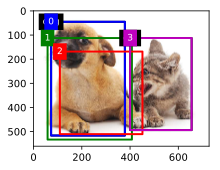

In [48]:
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,ground_truth[:,1:]*bbox_scale,['dog','cat'],'k')
show_bboxes(fig.axes,anchors*bbox_scale,['0','1','2','3','4']);

我们可以通过contrib.nd模块中的**MultiBoxTarget**函数来为锚框标注类别和偏移量。该函数将背景类别设为0，并令从零开始的目标类别的整数索引自加1（1为狗，2为猫）。我们通过expand_dims函数为锚框和真实边界框添加样本维，并构造形状为(批量大小, 包括背景的类别个数, 锚框数)的任意预测结果。

In [19]:
labels=contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0),ground_truth.expand_dims(axis=0),nd.zeros((1,3,5)))

In [20]:
labels

[
 [[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.40e+00  1.00e+01  2.59e+00
    7.18e+00 -1.20e+00  2.69e-01  1.68e+00 -1.57e+00  0.00e+00  0.00e+00
    0.00e+00  0.00e+00 -5.71e-01 -1.00e+00 -8.94e-07  6.26e-01]]
 <NDArray 1x20 @cpu(0)>, 
 [[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]
 <NDArray 1x20 @cpu(0)>, 
 [[0. 1. 2. 0. 2.]]
 <NDArray 1x5 @cpu(0)>]

返回的结果里有3项，均为NDArray。第三项表示为锚框标注的类别。

In [22]:
labels[2]


[[0. 1. 2. 0. 2.]]
<NDArray 1x5 @cpu(0)>

我们根据锚框与真实边界框在图像中的位置来分析这些标注的类别。首先，在所有的“锚框—真实边界框”的配对中，锚框 $A_4$ 与猫的真实边界框的交并比最大，因此锚框 $A_4$ 的类别标注为猫。不考虑锚框 $A_4$ 或猫的真实边界框，在剩余的“锚框—真实边界框”的配对中，最大交并比的配对为锚框 $A_1$ 和狗的真实边界框，因此锚框 $A_1$ 的类别标注为狗。接下来遍历未标注的剩余3个锚框：与锚框 $A_0$ 交并比最大的真实边界框的类别为狗，但交并比小于阈值（默认为0.5），因此类别标注为背景；与锚框 $A_2$ 交并比最大的真实边界框的类别为猫，且交并比大于阈值，因此类别标注为猫；与锚框 $A_3$ 交并比最大的真实边界框的类别为猫，但交并比小于阈值，因此类别标注为背景。

返回值的第二项为掩码（mask）变量，形状为(批量大小, 锚框个数的四倍)。掩码变量中的元素与每个锚框的4个偏移量一一对应。 由于我们不关心对背景的检测，有关负类的偏移量不应影响目标函数。通过按元素乘法，掩码变量中的0可以在计算目标函数之前过滤掉负类的偏移量。

In [23]:
labels[1]


[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]
<NDArray 1x20 @cpu(0)>

返回的第一项是为每个锚框标注的四个偏移量，其中负类锚框的偏移量标注为0。

In [25]:
labels[0]


[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.40e+00  1.00e+01  2.59e+00
   7.18e+00 -1.20e+00  2.69e-01  1.68e+00 -1.57e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00 -5.71e-01 -1.00e+00 -8.94e-07  6.26e-01]]
<NDArray 1x20 @cpu(0)>

## 输出预测边界框
在模型预测阶段，我们先为图像生成多个锚框，并为这些锚框一一预测类别和偏移量。随后，我们根据锚框及其预测偏移量得到预测边界框。当锚框数量较多时，同一个目标上可能会输出较多相似的预测边界框。为了使结果更加简洁，我们可以移除相似的预测边界框。常用的方法叫作非极大值抑制（non-maximum suppression，NMS）。

我们来描述一下非极大值抑制的工作原理。对于一个预测边界框 B ，模型会计算各个类别的预测概率。设其中最大的预测概率为 p ，该概率所对应的类别即 B 的预测类别。我们也将 p 称为预测边界框 B 的置信度。在同一图像上，我们将预测类别非背景的预测边界框按置信度从高到低排序，得到列表 L 。从 L 中选取置信度最高的预测边界框 $B_1$ 作为基准，将所有与 $B_1$ 的交并比大于某阈值的非基准预测边界框从 L 中移除。这里的阈值是预先设定的超参数。此时， L 保留了置信度最高的预测边界框并移除了与其相似的其他预测边界框。 接下来，从 L 中选取置信度第二高的预测边界框 $B_2$ 作为基准，将所有与 $B_2$ 的交并比大于某阈值的非基准预测边界框从 L 中移除。重复这一过程，直到 L 中所有的预测边界框都曾作为基准。此时 L 中任意一对预测边界框的交并比都小于阈值。最终，输出列表 L 中的所有预测边界框。

下面来看一个具体的例子。先构造4个锚框。简单起见，我们假设预测偏移量全是0：预测边界框即锚框。最后，我们构造每个类别的预测概率。

In [26]:
anchors=nd.array([[0.1,0.08,0.52,0.92],
                 [0.08,0.2,0.56,0.95],
                 [0.15,0.3,0.62,0.91],
                 [0.55,0.2,0.9,0.88]])
offset_preds=nd.array([0]*anchors.size)
cls_probs=nd.array([[0]*4, #背景的预测值
                   [0.9,0.8,0.7,0.1],#狗的预测值
                   [0.1,0.2,0.3,0.9]])#猫的预测值

In [27]:
[1]*4

[1, 1, 1, 1]

In [47]:
[[1,2]]*4

[[1, 2], [1, 2], [1, 2], [1, 2]]

在图像上打印预测边界框和它们的置信度。

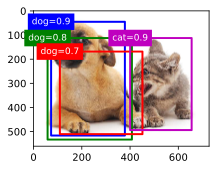

In [29]:
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,anchors*bbox_scale,['dog=0.9','dog=0.8','dog=0.7','cat=0.9'])

我们使用contrib.nd模块的**MultiBoxDetection**函数来执行非极大值抑制并设阈值为0.5。这里为NDArray输入都增加了样本维。我们看到，返回的结果的形状为(批量大小, 锚框个数, 6)。其中每一行的6个元素代表同一个预测边界框的输出信息。第一个元素是索引从0开始计数的预测类别（0为狗，1为猫），其中-1表示背景或在非极大值抑制中被移除。第二个元素是预测边界框的置信度。剩余的4个元素分别是预测边界框左上角的 x 和 y 轴坐标以及右下角的 x 和 y 轴坐标（值域在0到1之间）。

In [31]:
output=contrib.ndarray.MultiBoxDetection(cls_probs.expand_dims(axis=0),offset_preds.expand_dims(axis=0),
                                        anchors.expand_dims(axis=0),nms_threshold=0.5)
output


[[[ 0.    0.9   0.1   0.08  0.52  0.92]
  [ 1.    0.9   0.55  0.2   0.9   0.88]
  [-1.    0.8   0.08  0.2   0.56  0.95]
  [-1.    0.7   0.15  0.3   0.62  0.91]]]
<NDArray 1x4x6 @cpu(0)>

我们移除掉类别为-1的预测边界框，并可视化非极大值抑制保留的结果。

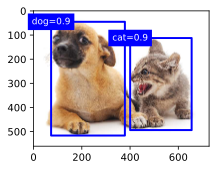

In [45]:
fig=d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0]==-1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes,[nd.array(i[2:])*bbox_scale],label);

实践中，我们可以在执行非极大值抑制前将置信度较低的预测边界框移除，从而减小非极大值抑制的计算量。我们还可以筛选非极大值抑制的输出，例如，只保留其中置信度较高的结果作为最终输出。

In [41]:
label = ('dog=', 'cat=')[0] + str(0.9)
label

'dog=0.9'

## 小结
* 以每个像素为中心，生成多个大小和宽高比不同的锚框。mxnet.contrib.ndarry.MultiBoxPrior()实现
* 交并比是两个边界框相交面积与相并面积之比。
* 在训练集中，为每个锚框标注两类标签：一是锚框所含目标的类别；二是真实边界框相对锚框的偏移量。MultiBoxTarget()实现
* 预测时，可以使用非极大值抑制来移除相似的预测边界框，从而令结果简洁。MultiBoxDetection()实现

In [46]:
[[1,2]]*4

[[1, 2], [1, 2], [1, 2], [1, 2]]